### Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler
from PIL import ImageFile
import itertools
import gc
import os
import time
import cv2

ImageFile.LOAD_TRUNCATED_IMAGES = True

start_time = time.time()


### Load and Prepare Data

In [2]:
# Load the CSV files
print("Loading CSV files...")
train_csv_path = r'D:\College Work\8th Sem\Internship\Dataset\archive\train\train.csv'
train_images_path = r'D:\College Work\8th Sem\Internship\Dataset\archive\train\images'

df0 = pd.read_csv(train_csv_path)

# Initialize empty lists to store file names and labels
file_names = []
labels = []

# Iterate through all image files in the specified directory
print("Loading images...")
for file in tqdm(sorted((Path(train_images_path).glob('*.*')))):
    label = os.path.basename(file)  # Extract the label from the file path using os.path.basename
    labels.append(label)  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list

# Print the total number of file names and labels
print("Total images:", len(file_names), len(labels))

# Create a pandas dataframe from the collected file names and labels
print("Creating dataframe...")
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

# Merge with df0
print("Merging dataframes...")
df = df.merge(df0, left_on='label', right_on='image', how='inner')
df.rename(columns={'image_x': 'image'}, inplace=True)
df.drop(['label', 'image_y'], axis=1, inplace=True)
label_dict = {1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tankers'}
df['label'] = df['category'].apply(lambda x: label_dict[x])
df.drop(['category'], axis=1, inplace=True)
print("DataFrame shape:", df.shape)
print("Unique labels:", df['label'].unique())


Loading CSV files...
Loading images...


100%|██████████████████████████████████████████████████████████████████████████| 8932/8932 [00:00<00:00, 289911.50it/s]

Total images: 8932 8932
Creating dataframe...
Merging dataframes...
DataFrame shape: (6252, 2)
Unique labels: ['Cruise' 'Military' 'Cargo' 'Tankers' 'Carrier']


### Oversample Minority Classes

In [3]:
# Random oversampling of minority class
y = df[['label']]
df = df.drop(['label'], axis=1)

print("Performing random oversampling...")
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)

del y
df['label'] = y_resampled
del y_resampled
gc.collect()

print("DataFrame shape after oversampling:", df.shape)


Performing random oversampling...
DataFrame shape after oversampling: (10600, 2)


### Split Data into Training and Testing Sets

In [4]:
# Split the data into training and testing sets
print("Splitting data into training and testing sets...")
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


Splitting data into training and testing sets...


### Define Image Data Generators

In [5]:
# Define image data generators
print("Defining image data generators...")
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


Defining image data generators...


### Create Data Generators

In [6]:
# Create the train and test generators
print("Creating train and test generators...")
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=(299, 299),  # Xception requires input size of 299x299
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Check the class indices to verify
print("Class indices:", train_generator.class_indices)


Creating train and test generators...
Found 8480 validated image filenames belonging to 5 classes.
Found 2120 validated image filenames belonging to 5 classes.
Class indices: {'Cargo': 0, 'Carrier': 1, 'Cruise': 2, 'Military': 3, 'Tankers': 4}


### Build and Compile Model

In [7]:
# Build the Xception Model
print("Building Xception model...")
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the layers of the Xception model except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)  # Manually specify the number of classes

# Create the model
print("Creating the model...")
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
print("Compiling the model...")
model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower the learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Building Xception model...
Creating the model...
Compiling the model...


### Train the Model

In [8]:
# Train the model
print("Training the model...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=5,  # Increase the number of epochs
)


Training the model...
Epoch 1/5


C:\Users\prith\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 721s 5s/step - accuracy: 0.5666 - loss: 1.1281 - val_accuracy: 0.8243 - val_loss: 0.4634
Epoch 2/5
  1/132 ━━━━━━━━━━━━━━━━━━━━ 9:17 4s/step - accuracy: 0.7656 - loss: 0.6483

C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7656 - loss: 0.6483 - val_accuracy: 1.0000 - val_loss: 0.0456
Epoch 3/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 717s 5s/step - accuracy: 0.7943 - loss: 0.5440 - val_accuracy: 0.8646 - val_loss: 0.3701
Epoch 4/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8750 - loss: 0.3693 - val_accuracy: 1.0000 - val_loss: 0.0109
Epoch 5/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 718s 5s/step - accuracy: 0.8379 - loss: 0.4437 - val_accuracy: 0.8906 - val_loss: 0.3034


### Plot Accuracy and Loss graphs

Plotting accuracy and loss graphs...


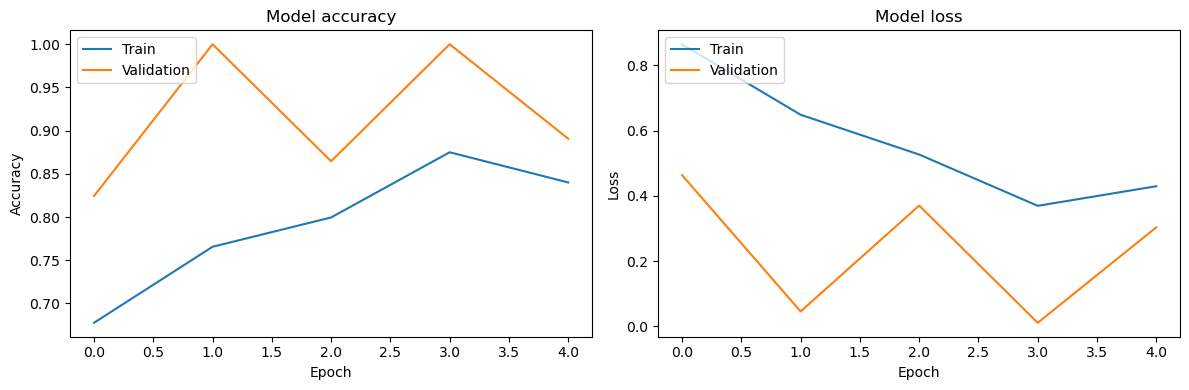

In [9]:
# Plot accuracy and loss graphs
print("Plotting accuracy and loss graphs...")
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


### Evaluate the Model

In [10]:
# Evaluate the model
print("Evaluating the model...")
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Print model predictions for debugging
print("Sample predictions:", y_pred[:10])
print("True labels:", test_generator.classes[:10])

# Generate the classification report
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# Get true labels
true_labels = test_generator.classes

# Get predicted labels
predicted_labels = np.argmax(Y_pred, axis=1)


Evaluating the model...
34/34 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step
Sample predictions: [3 4 0 3 4 1 4 0 2 1]
True labels: [3, 4, 0, 3, 4, 1, 2, 0, 2, 1]
Classification Report
              precision    recall  f1-score   support

       Cargo       0.80      0.81      0.81       424
     Carrier       0.97      0.95      0.96       424
      Cruise       0.92      0.96      0.94       424
    Military       0.94      0.96      0.95       424
     Tankers       0.83      0.78      0.81       424

    accuracy                           0.89      2120
   macro avg       0.89      0.89      0.89      2120
weighted avg       0.89      0.89      0.89      2120



### Plot Confusion Matrix

Accuracy: 0.8910
F1 Score: 0.8905


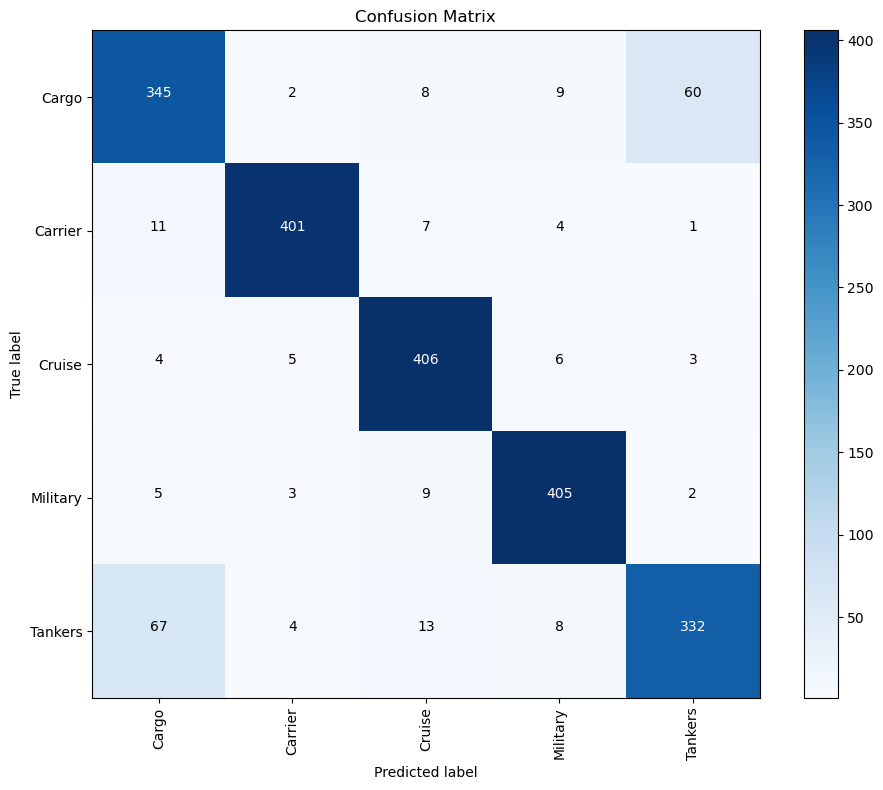


Classification report:

              precision    recall  f1-score   support

       Cargo     0.7986    0.8137    0.8061       424
     Carrier     0.9663    0.9458    0.9559       424
      Cruise     0.9165    0.9575    0.9366       424
    Military     0.9375    0.9552    0.9463       424
     Tankers     0.8342    0.7830    0.8078       424

    accuracy                         0.8910      2120
   macro avg     0.8906    0.8910    0.8905      2120
weighted avg     0.8906    0.8910    0.8905      2120



In [11]:
# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """

    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(target_names) <= 250:
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, target_names)

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(true_labels, predicted_labels, target_names=target_names, digits=4))


### Save the Model

In [12]:
# Save the model
print("Saving the model...")
model.save("model_xception.h5")

print("Total time taken:", round((time.time() - start_time) / 60, 2), "minutes.")


Saving the model...
Total time taken: 38.45 minutes.
